## libraries

In [78]:
import os
import sys
from pathlib import Path
from pprint import pformat
from tempfile import TemporaryDirectory
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import geopandas as gpd
import pooch
import flopy
import flopy.plot
import flopy.utils
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box
print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")


3.11.9 (main, Apr  2 2024, 13:43:44) [GCC 13.2.0]
numpy version: 1.26.3
matplotlib version: 3.9.2
flopy version: 3.9.2


## define simulation

In [75]:
# simulation setup
sim_name = 'rgtihm'
workspace = './model'
sim = flopy.mf6.MFSimulation(
    sim_name=sim_name,
    sim_ws=workspace,
    exe_name='mf6')
gwf = flopy.mf6.ModflowGwf(sim,
                           modelname=sim_name)
print("simulation and gwf packages created.")

simulation and gwf packages created.


## tdis

In [76]:
# tdis (temporal discretization) parameters
nper = 898
start_date = datetime(1940, 3, 1)
perioddata = []
for i in range(nper):
    month_start = start_date + timedelta(days=sum(p[0] for p in perioddata))
    if month_start.month == 12:
        month_end = datetime(month_start.year + 1, 1, 1)
    else:
        month_end = datetime(month_start.year, month_start.month + 1, 1)
    perlen = (month_end - month_start).days
    nstp = 2
    tsmult = 1.0
    perioddata.append((float(perlen), nstp, tsmult))

# create tdis
tdis = flopy.mf6.ModflowTdis(
    sim,
    time_units='days',
    nper=nper,
    perioddata=perioddata,
    start_date_time=start_date.strftime('%Y-%m-%d'),
)
print("tdis package created.")

tdis package created.


## dis

In [79]:
## discretization package. -99999 as nan and active area as idomain=0

# grid dimensions
nlay = 9
nrow = 912
ncol = 328

# cell sizes (feet, from RGTIHM.dis)
delr = np.full(ncol, 660.0)
delc = np.full(nrow, 660.0)

# top and bottom file paths (from NAM file)
top_file = '../owhm/model/2022/Data_Model_Arrays/layers/ElevFtDEMR.txt'
bot_files = [
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_RC2_ft.txt',   # bot layer 1
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF1_ft.txt', # bot layer 2
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF2_ft.txt', # bot layer 3
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF1_ft.txt', # bot layer 4
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF2_ft.txt', # bot layer 5
    '../owhm/model/2022/Data_Model_Arrays/layers/TopLSF1_ft.txt',  # bot layer 6
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_LSF2_ft.txt', # bot layer 7
    '../owhm/model/2022/Data_Model_Arrays/layers/TopBSMT_ft.txt',  # bot layer 8
    '../owhm/model/2022/Data_Model_Arrays/layers/BaseBSMT_ft.txt', # bot layer 9
]

# read top, handle -99999 as no data
try:
    top = np.loadtxt(top_file, dtype=float)
    if top.shape != (nrow, ncol):
        print(f"warning: {top_file} shape {top.shape} != ({nrow}, {ncol})")
        top = top.reshape(nrow, ncol)[:nrow, :ncol]
    top = np.where(top == -99999, np.nan, top)  # replace -99999 with NaN
except FileNotFoundError:
    print(f"error: {top_file} not found. DIS requires this file. Exiting.")
    import sys
    sys.exit(1)
except Exception as e:
    print(f"error reading {top_file}: {e}. Exiting.")
    import sys
    sys.exit(1)

# read bottoms into 3d array, handle -99999 as no data
botm = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {bot_file} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        data = np.where(data == -99999, np.nan, data)  # replace -99999 with NaN
        botm[lay] = data
    except FileNotFoundError:
        print(f"error: {bot_file} not found. DIS requires this file. Exiting.")
        import sys
        sys.exit(1)
    except Exception as e:
        print(f"error reading {bot_file}: {e}. Exiting.")
        import sys
        sys.exit(1)

# read shapefile for active area
shp_path = './shps/active_area.shp'
try:
    gdf = gpd.read_file(shp_path)
    if len(gdf) != 1:
        print(f"Warning: Expected 1 feature in shapefile, found {len(gdf)}. Using first feature.")
    geometry = gdf.geometry.iloc[0]  # get the single polygon
except FileNotFoundError:
    print(f"error: {shp_path} not found. Using all active cells. Exiting.")
    import sys
    sys.exit(1)
except Exception as e:
    print(f"error reading {shp_path}: {e}. Using all active cells. Exiting.")
    import sys
    sys.exit(1)

# get DIS rotation and origin (safely, assuming dis might not exist yet)
try:
    xorigin = dis.xorigin.get_data() if hasattr(dis, 'xorigin') else 0.0
    yorigin = dis.yorigin.get_data() if hasattr(dis, 'yorigin') else 0.0
    angrot = dis.angrot.get_data() if hasattr(dis, 'angrot') else 0.0
except NameError:
    print("Warning: 'dis' not defined yet. Using default origin and rotation (0, 0, 0).")
    xorigin, yorigin, angrot = 0.0, 0.0, 0.0

# create model grid bounds (rotated coordinates)
x = np.arange(ncol) * delr[0]
y = np.arange(nrow) * delc[0]
X, Y = np.meshgrid(x, y)
X_rot = xorigin + X * np.cos(np.radians(angrot)) - Y * np.sin(np.radians(angrot))
Y_rot = yorigin + X * np.sin(np.radians(angrot)) + Y * np.cos(np.radians(angrot))

# define grid bounds for rasterization (min/max of rotated coordinates)
minx, maxx = X_rot.min(), X_rot.max()
miny, maxy = Y_rot.min(), Y_rot.max()

# rasterize shapefile to match grid
transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, ncol, nrow)
raster = rasterize([geometry], out_shape=(nrow, ncol), transform=transform, fill=0, default_value=1, dtype='int32')

# create 3D idomain (all layers) using only shapefile, no NaN override
idomain = np.ones((nlay, nrow, ncol), dtype=int)  # start with all active
for lay in range(nlay):
    idomain[lay] = raster  # apply raster to each layer (1 inside shapefile, 0 outside)

# create dis package with rotation and origin
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    length_units='FEET',
    xorigin=xorigin,
    yorigin=yorigin,
    angrot=angrot,
)
print("dis package created with idomain from shapefile only.")

dis package created with idomain from shapefile only.


## oc 

In [80]:
# create oc (output control) package
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=f'{sim_name}.cbc',
    head_filerecord=f'{sim_name}.hds',
    headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 6, 'GENERAL')],
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
    printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
)
print("oc package created.")

oc package created.


## ims

In [81]:
# iterative model solution (ims)
ims = flopy.mf6.ModflowIms(
    sim,
    pname='ims',
    complexity='simple',
    outer_dvclose=1e-4,
    outer_maximum=500,
    inner_maximum=100,
    inner_dvclose=1e-4,
    rcloserecord=0.001,
    linear_acceleration='cg',
    relaxation_factor=0.97,
)

## ic

In [82]:
# grid dimensions (sam as  dis)
nlay = 9
nrow = 912
ncol = 328

# head file paths
head_files = [
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY1.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY2.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY3.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY4.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY5.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY6.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY7.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY8.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY9.txt',
]

# read heads into 3d array, handle -99999 as no data
strt = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, head_file in enumerate(head_files):
    try:
        data = np.loadtxt(head_file, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {head_file} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        data = np.where(data == -99999, np.nan, data)  # replace -99999 with NaN
        strt[lay] = data
    except FileNotFoundError:
        print(f"error: {head_file} not found. IC requires this file. Exiting.")
        import sys
        sys.exit(1)
    except Exception as e:
        print(f"error reading {head_file}: {e}. Exiting.")
        import sys
        sys.exit(1)

# update strt to match idomain (inactive cells from DIS shapefile)
idomain = dis.idomain.array  # from updated DIS
strt[idomain == 0] = np.nan  # set inactive cells (outside shapefile) to NaN

# create ic package
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
print("ic package created with -99999 as no-data, idomain from shapefile.")

ic package created with -99999 as no-data, idomain from shapefile.


## npf package

In [83]:
## node property flow package
# zone file paths
zone_files = {
    'znlayrc': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/RC1_zonecode.txt',
    'znlay3': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF1_zonecode.txt',
    'znlay4': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF2_zonecode.txt',
    'znlay5': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF1_zonecode.txt',
    'znlay6': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF2_zonecode.txt',
    'znlay7': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF1_zonecode.txt',
    'znlay8': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF2_zonecode.txt',
    'znlay9': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/BSMT_zonecodeS.txt',
}

# read zone arrays
zone_arrays = {}
for name, filepath in zone_files.items():
    try:
        data = np.loadtxt(filepath, dtype=int)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        zone_arrays[name] = data
    except FileNotFoundError:
        print(f"error: {filepath} not found. NPF requires this file. Exiting.")
        import sys
        sys.exit(1)
    except Exception as e:
        print(f"error reading {filepath}: {e}. Exiting.")
        import sys
        sys.exit(1)

# layer-to-zone mapping
layer_zones = {
    0: 'znlayrc', 1: 'znlayrc', 2: 'znlay3', 3: 'znlay4',
    4: 'znlay5', 5: 'znlay6', 6: 'znlay7', 7: 'znlay8', 8: 'znlay9'
}

# pval data (partial, expand with all entries from RGTIHM.PVL)
pval_data = {
    'l1hk10': 100.0, 'l1hk20': 30.0, 'l1vk10': 1.091422, 'l1vk20': 1.2296545,
    # add all hk, vani from RGTIHM.PVL, e.g.:
    # 'l1hk30': 0.2629016, 'l2hk10': 100.0, 'l3hk15': 100.0, ...
}

# initialize arrays with no-data handling
hk = np.ones((nlay, nrow, ncol), dtype=float) * 1e-10  # default K > 0
vani = np.ones((nlay, nrow, ncol), dtype=float) * 1.0
k33 = hk * vani
icelltype = [0] * nlay

# populate hk and vani, handle -99999 as no data
for param, value in pval_data.items():
    lay = int(param[1]) - 1
    iz = int(param.split('hk' if 'hk' in param else 'vk')[1])
    zone_array = zone_arrays[layer_zones[lay]]
    mask = (zone_array == iz)
    if value == -99999:  # treat -99999 as no data
        hk[lay][mask] = np.nan
        vani[lay][mask] = np.nan
    else:
        hk[lay][mask] = max(value, 1e-10)  # ensure K > 0
        if 'vk' in param and value != -99999:
            vani[lay][mask] = max(value, 1e-10)
            k33[lay][mask] = hk[lay][mask] * vani[lay][mask]

# update hk, vani, k33 to match idomain (inactive cells from DIS shapefile)
idomain = dis.idomain.array  # from updated DIS
hk[idomain == 0] = np.nan  # set inactive cells to NaN
vani[idomain == 0] = np.nan
k33[idomain == 0] = np.nan

# create npf
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=True,
    icelltype=icelltype,
    k=hk,
    k33=k33,
    save_specific_discharge=True,
    alternative_cell_averaging="harmonic",
)
print("npf package created with -99999 as no-data, idomain from shapefile.")

npf package created with -99999 as no-data, idomain from shapefile.


## sto

In [84]:
# multiplier file paths
mult_files = {
    'uc_rc': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/RC1_UC.txt',
    'uc_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',
    'cf_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_CF.txt',
    'uc_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',
    'cf_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_CF.txt',
    'uc_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',
    'cf_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_CF.txt',
    'uc_bd': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt',
    'cf_bd': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_CF.txt',
    'thk_rc1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_RC1_ft.txt',
    'thk_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_USF1_ft.txt',
    'thk_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_MSF1_ft.txt',
    'thk_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_LSF1_ft.txt',
    'thk_bd': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_BSMT_ft.txt',
}

# read multiplier arrays, handle -99999 as no data
mult_arrays = {}
for name, filepath in mult_files.items():
    try:
        data = np.loadtxt(filepath, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        data = np.where(data == -99999, np.nan, data)  # replace -99999 with NaN
        mult_arrays[name] = data
    except FileNotFoundError:
        print(f"error: {filepath} not found. STO requires this file. Exiting.")
        import sys
        sys.exit(1)
    except Exception as e:
        print(f"error reading {filepath}: {e}. Exiting.")
        import sys
        sys.exit(1)

# constants from mul
ss_base = 0.000001
sy_base = 0.30
phi = {'rc': 0.25, 'us': 0.22, 'ms': 0.12, 'ls': 0.08, 'bd': 0.07}
comp_h2o = 1.432195e-06
offset = 0.0001

# pval data (partial, expand with all entries from RGTIHM.PVL)
pval_data = {
    'l2ss10': 5.0, 'l2ss20': 25.0, 'l2ss30': 8.2691995, 'l2ss51': 8.758604,
    'l3ss15': 1.0955468, 'l3ss25': 2.9409115, 'l3ss35': 3.33, 'l3ss50': 1.069701,
    'l1sy10': 1.0, 'l1sy20': 1.0, 'l1sy30': 0.825, 'l1sy51': 1.0,
    'l3sy15': 0.50864162, 'l3sy25': 0.87375378, 'l3sy35': 0.59566227,
    # add all ss, sy from RGTIHM.PVL
}

# initialize arrays with no-data handling
ss = np.ones((nlay, nrow, ncol), dtype=float) * ss_base
sy = np.ones((nlay, nrow, ncol), dtype=float) * sy_base
iconvert = [0] * nlay

# compute ss and sy per expressions, handle NaN
for lay in range(nlay):
    zone_array = zone_arrays[layer_zones[lay]]
    if lay in [0, 1]:  # rc
        thk = mult_arrays['thk_rc1']
        uc = mult_arrays['uc_rc']
        sy[lay] = np.where(np.isnan(thk) | np.isnan(uc), np.nan, 
                           ((sy_base / (thk + offset)) + (phi['rc'] * comp_h2o)) * uc)
        ss[lay] = np.where(np.isnan(thk) | np.isnan(uc), np.nan, 
                           (phi['rc'] * comp_h2o + ss_base) * uc)
    elif lay in [2, 3]:  # usf
        thk = mult_arrays['thk_usf1']
        uc = mult_arrays['uc_usf1']
        cf = mult_arrays['cf_usf1']
        sy[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((sy_base / (thk + offset)) * uc) + ((phi['us'] * comp_h2o) * uc))
        ss[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((phi['us'] * comp_h2o) * cf) + (ss_base * cf) if lay == 2 else \
                           ((phi['us'] * comp_h2o + ss_base) * (cf + uc)))
    elif lay in [4, 5]:  # msf
        thk = mult_arrays['thk_msf1']
        uc = mult_arrays['uc_msf1']
        cf = mult_arrays['cf_msf1']
        sy[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((sy_base / (thk + offset)) * uc) + ((phi['ms'] * comp_h2o) * uc))
        ss[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((phi['ms'] * comp_h2o) * cf) + (ss_base * cf) if lay == 4 else \
                           ((phi['ms'] * comp_h2o + ss_base) * (cf + uc)))
    elif lay in [6, 7]:  # lsf
        thk = mult_arrays['thk_lsf1']
        uc = mult_arrays['uc_lsf1']
        cf = mult_arrays['cf_lsf1']
        sy[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((sy_base / (thk + offset)) * uc) + ((phi['ls'] * comp_h2o) * uc))
        ss[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((phi['ls'] * comp_h2o) * cf) + (ss_base * cf) if lay == 6 else \
                           ((phi['ls'] * comp_h2o + ss_base) * (cf + uc)))
    elif lay == 8:  # bd
        thk = mult_arrays['thk_bd']
        uc = mult_arrays['uc_bd']
        cf = mult_arrays['cf_bd']
        sy[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((sy_base / (thk + offset)) * uc) + ((phi['bd'] * comp_h2o) * uc))
        ss[lay] = np.where(np.isnan(thk) | np.isnan(uc) | np.isnan(cf), np.nan, 
                           ((phi['bd'] * comp_h2o) * cf) + (ss_base * cf))

# apply pval multipliers, handle NaN
for param, value in pval_data.items():
    lay = int(param[1]) - 1
    iz = int(param.split('ss' if 'ss' in param else 'sy')[1])
    zone_array = zone_arrays[layer_zones[lay]]
    mask = (zone_array == iz)
    if value == -99999:  # treat -99999 as no data
        ss[lay][mask] = np.nan
        sy[lay][mask] = np.nan
    else:
        ss[lay][mask] = np.where(np.isnan(ss[lay][mask]), np.nan, ss[lay][mask] * value)
        sy[lay][mask] = np.where(np.isnan(sy[lay][mask]), np.nan, sy[lay][mask] * value)

# update ss and sy to match idomain (inactive cells from DIS shapefile)
idomain = dis.idomain.array  # from updated DIS
ss[idomain == 0] = np.nan  # set inactive cells (outside shapefile) to NaN
sy[idomain == 0] = np.nan

# create sto
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=iconvert,
    ss=ss,
    sy=sy,
    transient=True,
)
print("sto package created with -99999 as no-data, idomain from shapefile.")

sto package created with -99999 as no-data, idomain from shapefile.


## working dis with nan as idomain=0

In [69]:
# grid dimensions
nlay = 9
nrow = 912
ncol = 328

# cell sizes (feet, from RGTIHM.dis)
delr = np.full(ncol, 660.0)
delc = np.full(nrow, 660.0)

# top and bottom file paths (from NAM file)
top_file = '../owhm/model/2022/Data_Model_Arrays/layers/ElevFtDEMR.txt'
bot_files = [
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_RC2_ft.txt',   # bot layer 1
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF1_ft.txt', # bot layer 2
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF2_ft.txt', # bot layer 3
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF1_ft.txt', # bot layer 4
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF2_ft.txt', # bot layer 5
    '../owhm/model/2022/Data_Model_Arrays/layers/TopLSF1_ft.txt',  # bot layer 6
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_LSF2_ft.txt', # bot layer 7
    '../owhm/model/2022/Data_Model_Arrays/layers/TopBSMT_ft.txt',  # bot layer 8
    '../owhm/model/2022/Data_Model_Arrays/layers/BaseBSMT_ft.txt', # bot layer 9
]

# read top, handle -99999 as no data
try:
    top = np.loadtxt(top_file, dtype=float)
    if top.shape != (nrow, ncol):
        print(f"warning: {top_file} shape {top.shape} != ({nrow}, {ncol})")
        top = top.reshape(nrow, ncol)[:nrow, :ncol]
    top = np.where(top == -99999, np.nan, top)  # replace -99999 with NaN
except FileNotFoundError:
    print(f"error: {top_file} not found. DIS requires this file. Exiting.")
    import sys
    sys.exit(1)
except Exception as e:
    print(f"error reading {top_file}: {e}. Exiting.")
    import sys
    sys.exit(1)

# read bottoms into 3d array, handle -99999 as no data
botm = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {bot_file} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        data = np.where(data == -99999, np.nan, data)  # replace -99999 with NaN
        botm[lay] = data
    except FileNotFoundError:
        print(f"error: {bot_file} not found. DIS requires this file. Exiting.")
        import sys
        sys.exit(1)
    except Exception as e:
        print(f"error reading {bot_file}: {e}. Exiting.")
        import sys
        sys.exit(1)

# read shapefile for active area
shp_path = './shps/active_area.shp'
try:
    gdf = gpd.read_file(shp_path)
    if len(gdf) != 1:
        print(f"Warning: Expected 1 feature in shapefile, found {len(gdf)}. Using first feature.")
    geometry = gdf.geometry.iloc[0]  # get the single polygon
except FileNotFoundError:
    print(f"error: {shp_path} not found. Using all active cells. Exiting.")
    import sys
    sys.exit(1)
except Exception as e:
    print(f"error reading {shp_path}: {e}. Using all active cells. Exiting.")
    import sys
    sys.exit(1)

# get DIS rotation and origin
xorigin = dis.xorigin.get_data() if hasattr(dis, 'xorigin') else 0.0
yorigin = dis.yorigin.get_data() if hasattr(dis, 'yorigin') else 0.0
angrot = dis.angrot.get_data() if hasattr(dis, 'angrot') else 0.0

# create model grid bounds (rotated coordinates)
x = np.arange(ncol) * delr[0]
y = np.arange(nrow) * delc[0]
X, Y = np.meshgrid(x, y)
X_rot = xorigin + X * np.cos(np.radians(angrot)) - Y * np.sin(np.radians(angrot))
Y_rot = yorigin + X * np.sin(np.radians(angrot)) + Y * np.cos(np.radians(angrot))

# define grid bounds for rasterization (min/max of rotated coordinates)
minx, maxx = X_rot.min(), X_rot.max()
miny, maxy = Y_rot.min(), Y_rot.max()

# rasterize shapefile to match grid
transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, ncol, nrow)
raster = rasterize([geometry], out_shape=(nrow, ncol), transform=transform, fill=0, default_value=1, dtype='int32')

# create 3D idomain (all layers)
idomain = np.ones((nlay, nrow, ncol), dtype=int)  # start with all active
for lay in range(nlay):
    idomain[lay] = raster  # apply raster to each layer

# handle NaN from -99999 in top/botm (override shapefile if NaN)
top_nan = np.isnan(top)  # shape (912, 328)
top_nan_3d = np.repeat(top_nan[np.newaxis, :, :], nlay, axis=0)  # shape (9, 912, 328)
idomain[top_nan_3d] = 0  # inactive if top is NaN

for lay in range(nlay):
    botm_nan = np.isnan(botm[lay])  # shape (912, 328)
    idomain[lay, botm_nan] = 0  # inactive if botm is NaN

# create dis package with rotation and origin
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    length_units='FEET',
    xorigin=xorigin,
    yorigin=yorigin,
    angrot=angrot,
)
print("dis package created (-99999 as NaN)")

dis package created with -99999 handled as no data.


In [65]:
# hfb, wel, maw, sfr, ghb, et, 

## write and run

In [85]:
# write simulation
sim.write_simulation()

# optionally run simulation (uncomment to test)
# sim.run_simulation()

print("simulation written to ./mf6_model directory. Check for errors.")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model rgtihm...
    writing model name file...
    writing package dis...
    writing package oc...
    writing package ic...
    writing package npf...
    writing package sto...
simulation written to ./mf6_model directory. Check for errors.


top shape: (912, 328), expected: (912, 328)
botm shape: (9, 912, 328), expected: (9, 912, 328)
hk shape: (2692224,), expected: (9, 912, 328)


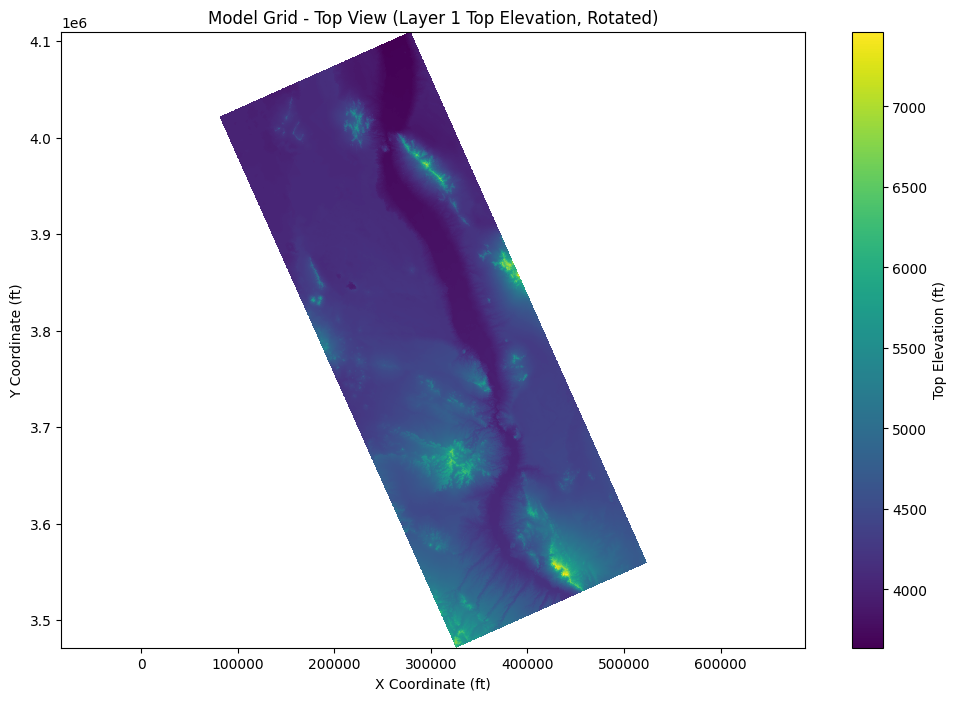

Skipping K plot: hk shape invalid
Skipping thickness plot: hk shape invalid
Using gray fill: hk shape invalid


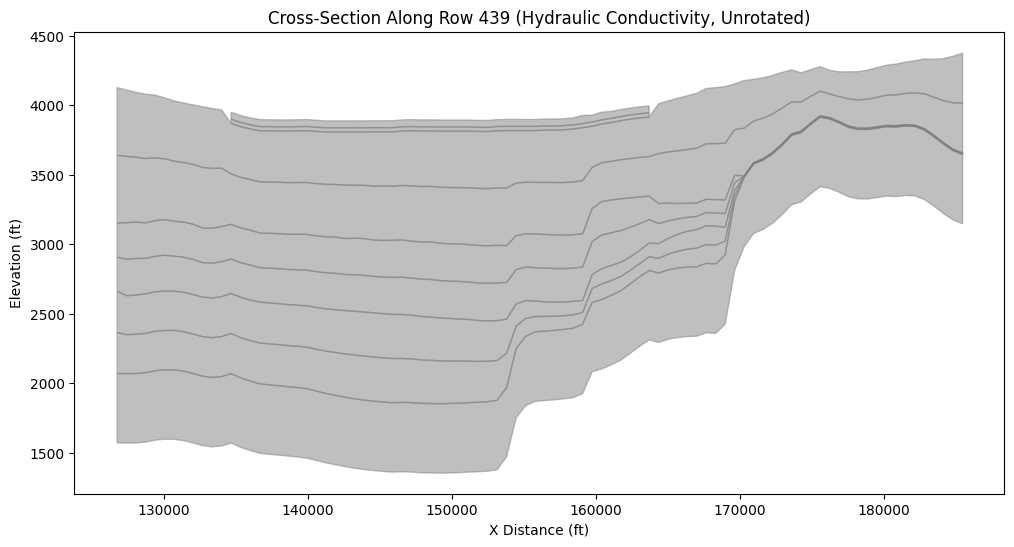

Using gray fill: hk shape invalid


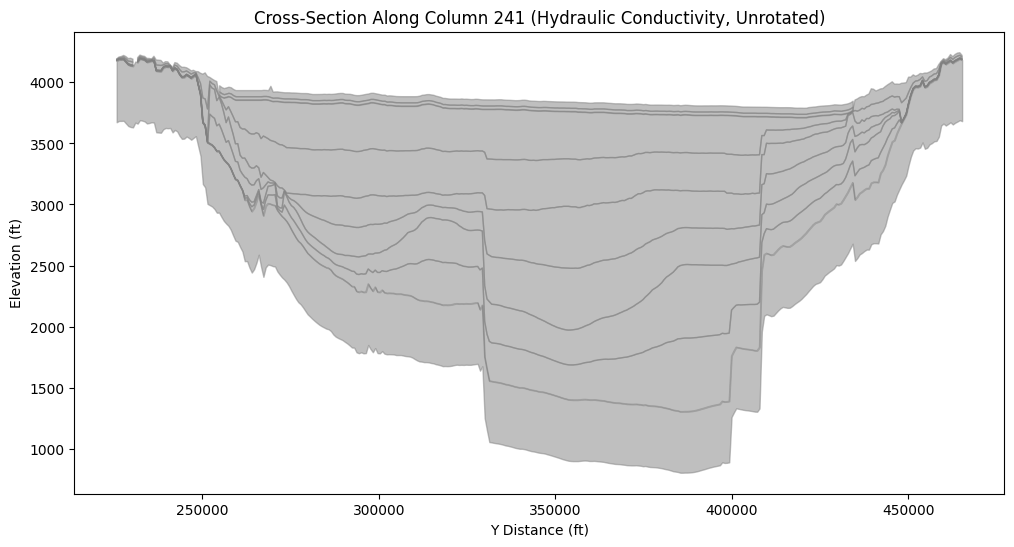

Skipping 3D plot: hk shape invalid


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D

# extract data from existing packages (assumes Cells 0-5 ran)
delr = dis.delr.array  # cell width (660 ft)
delc = dis.delc.array  # cell height (660 ft)
top = dis.top.array    # top elevation (912, 328)
botm = dis.botm.array  # bottom elevations (9, 912, 328)
hk = npf.k.array       # horizontal hydraulic conductivity (9, 912, 328)
ss = sto.ss.array      # specific storage (9, 912, 328)

# debug shapes
print(f"top shape: {top.shape}, expected: ({nrow}, {ncol})")
print(f"botm shape: {botm.shape}, expected: ({nlay}, {nrow}, {ncol})")
print(f"hk shape: {hk.shape}, expected: ({nlay}, {nrow}, {ncol})")

# calculate real-world coordinates with rotation
xorigin = dis.xorigin.get_data()
yorigin = dis.yorigin.get_data()
angrot = dis.angrot.get_data()  # 24.0 degrees
x = np.arange(ncol) * delr[0]  # unrotated x (ft)
y = np.arange(nrow) * delc[0]  # unrotated y (ft)
X, Y = np.meshgrid(x, y)
X_rot = xorigin + X * np.cos(np.radians(angrot)) - Y * np.sin(np.radians(angrot))
Y_rot = yorigin + X * np.sin(np.radians(angrot)) + Y * np.cos(np.radians(angrot))

# 1. plot model grid (top view, rotated real-world coordinates)
plt.figure(figsize=(12, 8))
plt.title("Model Grid - Top View (Layer 1 Top Elevation, Rotated)")
plt.pcolormesh(X_rot, Y_rot, top, cmap='viridis')
plt.colorbar(label="Top Elevation (ft)")
plt.xlabel("X Coordinate (ft)")
plt.ylabel("Y Coordinate (ft)")
plt.axis('equal')  # preserve aspect ratio
plt.show()

# 2. plot geology (hydraulic conductivity, layer 1, rotated)
if hk.shape == (nlay, nrow, ncol):
    plt.figure(figsize=(12, 8))
    plt.title("Horizontal Hydraulic Conductivity - Layer 1 (Rotated)")
    hk_layer1 = np.where(np.isnan(hk[0]), np.nan, hk[0])  # handle NaN
    plt.pcolormesh(X_rot, Y_rot, hk_layer1, cmap='jet', norm=LogNorm(vmin=1e-10, vmax=np.max(hk[~np.isnan(hk)])))
    plt.colorbar(label="K (ft/day)")
    plt.xlabel("X Coordinate (ft)")
    plt.ylabel("Y Coordinate (ft)")
    plt.axis('equal')
    plt.show()
else:
    print("Skipping K plot: hk shape invalid")

# 3. plot layer thickness (average per layer, rotated)
if hk.shape == (nlay, nrow, ncol):
    plt.figure(figsize=(12, 8))
    plt.title("Average Layer Thickness (Rotated)")
    thickness = np.zeros((nlay, nrow, ncol))
    for lay in range(nlay):
        thickness[lay] = top - botm[lay] if lay == 0 else botm[lay - 1] - botm[lay]
    avg_thickness = np.nanmean(thickness, axis=0)  # average thickness across layers, ignoring NaN
    plt.pcolormesh(X_rot, Y_rot, avg_thickness, cmap='Blues')
    plt.colorbar(label="Thickness (ft)")
    plt.xlabel("X Coordinate (ft)")
    plt.ylabel("Y Coordinate (ft)")
    plt.axis('equal')
    plt.show()
else:
    print("Skipping thickness plot: hk shape invalid")

# 4. cross-section along row 438 (near LRG-3616-S, unrotated for simplicity)
row_xs = 438  # 0-based, OWHM 439
x = np.arange(ncol) * delr[0]  # unrotated x (ft)
z = np.vstack([top[row_xs, :], botm[:, row_xs, :]])  # shape: (10, 328), top + 9 botms

plt.figure(figsize=(12, 6))
plt.title(f"Cross-Section Along Row {row_xs + 1} (Hydraulic Conductivity, Unrotated)")
if hk.shape == (nlay, nrow, ncol):
    for lay in range(nlay):
        hk_layer = np.where(np.isnan(hk[lay, row_xs, :]), np.nan, hk[lay, row_xs, :])
        if np.any(~np.isnan(hk_layer)):
            k_mean = np.log10(hk_layer[~np.isnan(hk_layer)]).mean() / np.log10(np.max(hk[~np.isnan(hk)]))
            plt.fill_between(x, z[lay, :], z[lay + 1, :], 
                             facecolor=plt.cm.jet(k_mean) if not np.all(np.isnan(hk_layer)) else 'gray',
                             alpha=0.7 if not np.all(np.isnan(hk_layer)) else 0.5)
        else:
            plt.fill_between(x, z[lay, :], z[lay + 1, :], color='gray', alpha=0.5)
    plt.colorbar(plt.cm.ScalarMappable(norm=LogNorm(vmin=1e-10, vmax=np.max(hk[~np.isnan(hk)])), cmap='jet'), 
                 label="K (ft/day)")
else:
    for lay in range(nlay):
        plt.fill_between(x, z[lay, :], z[lay + 1, :], color='gray', alpha=0.5)
    print("Using gray fill: hk shape invalid")
plt.xlabel("X Distance (ft)")
plt.ylabel("Elevation (ft)")
plt.show()

# 5. cross-section along column 240 (near LRG-3616-S, unrotated for simplicity)
col_xs = 240  # 0-based, OWHM 241
y = np.arange(nrow) * delc[0]  # unrotated y (ft)
z = np.vstack([top[:, col_xs], botm[:, :, col_xs]])  # shape: (10, 912), top + 9 botms (corrected)

plt.figure(figsize=(12, 6))
plt.title(f"Cross-Section Along Column {col_xs + 1} (Hydraulic Conductivity, Unrotated)")
if hk.shape == (nlay, nrow, ncol):
    for lay in range(nlay):
        hk_layer = np.where(np.isnan(hk[lay, :, col_xs]), np.nan, hk[lay, :, col_xs])
        if np.any(~np.isnan(hk_layer)):
            k_mean = np.log10(hk_layer[~np.isnan(hk_layer)]).mean() / np.log10(np.max(hk[~np.isnan(hk)]))
            plt.fill_between(y, z[lay, :], z[lay + 1, :],
                             facecolor=plt.cm.jet(k_mean) if not np.all(np.isnan(hk_layer)) else 'gray',
                             alpha=0.7 if not np.all(np.isnan(hk_layer)) else 0.5)
        else:
            plt.fill_between(y, z[lay, :], z[lay + 1, :], color='gray', alpha=0.5)
    plt.colorbar(plt.cm.ScalarMappable(norm=LogNorm(vmin=1e-10, vmax=np.max(hk[~np.isnan(hk)])), cmap='jet'), 
                 label="K (ft/day)")
else:
    for lay in range(nlay):
        plt.fill_between(y, z[lay, :], z[lay + 1, :], color='gray', alpha=0.5)
    print("Using gray fill: hk shape invalid")
plt.xlabel("Y Distance (ft)")
plt.ylabel("Elevation (ft)")
plt.show()

# 6. 3D perspective of top elevation (rotated, optional)
if hk.shape == (nlay, nrow, ncol):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    plt.title("3D Perspective of Top Elevation (Rotated)")
    surf = ax.plot_surface(X_rot, Y_rot, top, cmap='viridis')
    plt.colorbar(surf, shrink=0.5, aspect=5, label="Top Elevation (ft)")
    ax.set_xlabel("X Coordinate (ft)")
    ax.set_ylabel("Y Coordinate (ft)")
    ax.set_zlabel("Elevation (ft)")
    plt.show()
else:
    print("Skipping 3D plot: hk shape invalid")